 GROUP COMPONENTS:
- Tito Tamburini
- Angelo Mandara
- Enrico Grimaldi
- Claudiu Gabriel Gheorghiu
- Giuseppe Di Poce


# Fraudulent Transactions Detection

### Context
We are going to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

### Content

Data Dictionary:

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

**Exploratory Data Analysis (EDA)** 

In [123]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor #multi-collinearity

In [32]:
# Reading the csv file
data=pd.read_csv('Fraud.csv')

In [6]:
#Let's take a look to the data
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


There are 3 categorical variables (nameOrig, type and nameDest), we will decide how to treat them.

In [10]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in our dataset but we must remember that, as already said before, "oldbalanceDest" and "newbalanceDest" have not information for customers that start with M (Merchants).

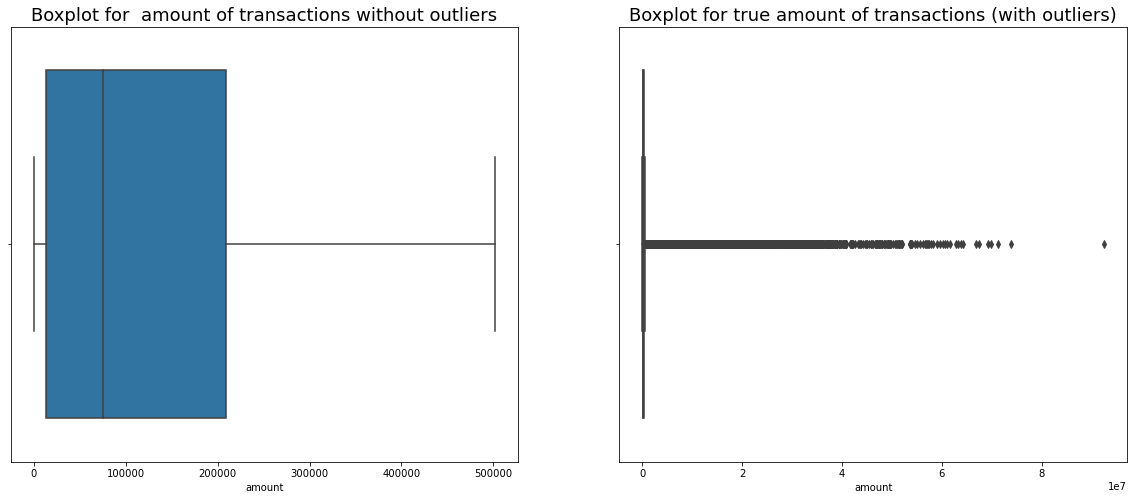

'\nplt.figure(figsize=(20, 8))\n\none = plt.subplot(1, 2, 1)\none.set_title("Boxplot for  amount of transactions with outliers", \n             {"fontsize":18})\ndata[\'isFraud\'].plot(kind=\'box\',vert=False)\n\ntwo = plt.subplot(1, 2, 2)\ntwo.set_title("Boxplot for  amount of transactions without outliers", \n             {"fontsize":18})\ndata[\'isFraud\'].plot.box(showfliers=False,vert=False)\nplt.show()\n'

In [13]:
plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Boxplot for  amount of transactions without outliers", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = False)

two = plt.subplot(1, 2, 2)
two.set_title("Boxplot for true amount of transactions (with outliers)", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = True)

plt.show()

Observing on the right the "true" **amount** is heavy the presence of outliers: the box is flat. Visually the imagine on the left tells us expicitely the distibution it's strongly asymmetric (mean > median). The most (75%) of transactions are under 208'722$, on average 179'862$, 50% < 74'872$.
In the next cell the statistics. 

In [29]:
print(data.amount.describe().to_markdown())
print("Median : " + str(median(data.amount)))

|       |           amount |
|:------|-----------------:|
| count |      6.36262e+06 |
| mean  | 179862           |
| std   | 603858           |
| min   |      0           |
| 25%   |  13389.6         |
| 50%   |  74871.9         |
| 75%   | 208721           |
| max   |      9.24455e+07 |
Median : 74871.94


Let's take a look at the number of fraud and legit transaction. Then more strictly which types are the "dangerous".

In [80]:
print("In absolute : \n" + str(data.isFraud.value_counts()))
print("In proportion : \n" + str(data.isFraud.value_counts(1)))

In absolute : 
0    6354407
1       8213
Name: isFraud, dtype: int64
In proportion : 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


c:\Users\claas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\claas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


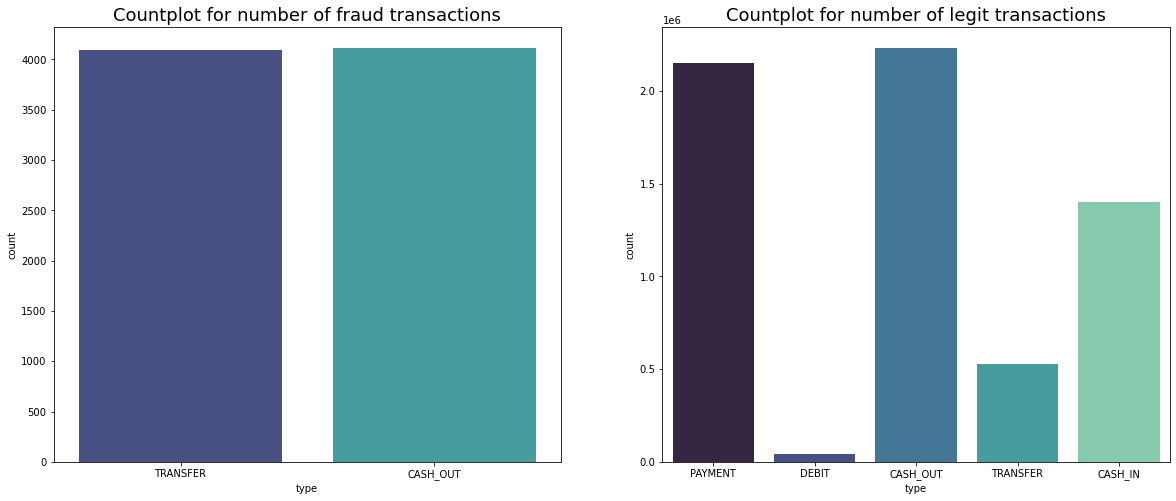

In [91]:
# dataset divided by isFraud
F=data[data.isFraud==1]
NF=data[data.isFraud==0]


plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Countplot for number of fraud transactions", 
             {"fontsize":18})
sns.countplot(F.type, palette='mako')

two = plt.subplot(1, 2, 2)
two.set_title("Countplot for number of legit transactions", 
             {"fontsize":18})
sns.countplot(NF.type, palette='mako')

plt.show()

In [93]:
print("Number of not fraud transaction per type : \n " + str(NF.type.value_counts()) + "\n")
print("Number of fraud transaction per type : \n " + str(F.type.value_counts()))

Number of not fraud transaction per type : 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

Number of fraud transaction per type : 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


The number of fraud movements is 8213, the 0.1% of the total. They are divided between the types "CASH_OUT" and "TRANSER" and equidistribuited respect to the amount.

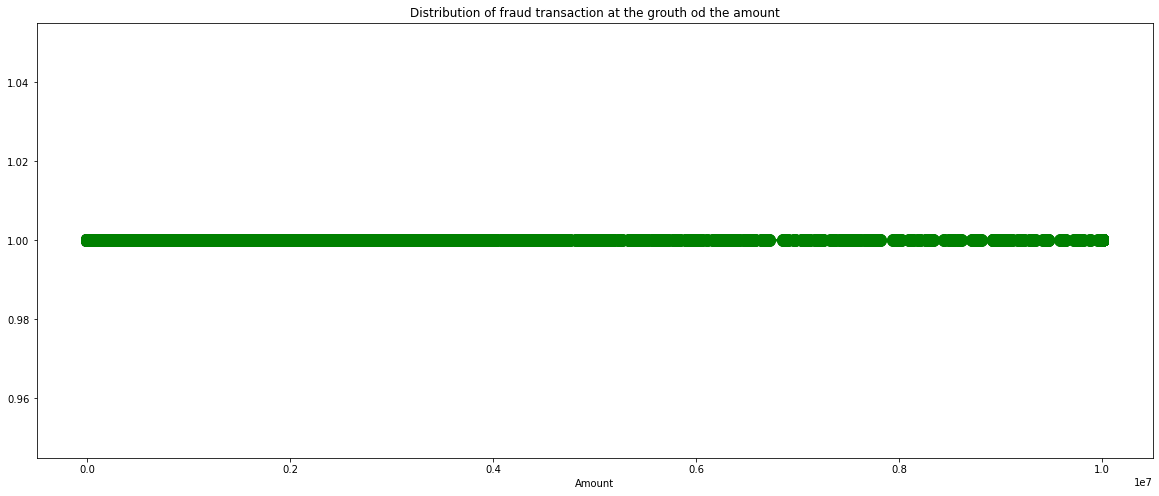

In [120]:
plt.figure(figsize=(20, 8))
plt.plot(F.amount,F.isFraud, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.title("Distribution of fraud transaction at the grouth od the amount", fontdict=None, loc='center')
plt.xlabel("Amount")
plt.show()

In [13]:
print("Total Unique Values in nameOrig", data['nameOrig'].nunique())

Total Unique Values in nameOrig 6353307


In [18]:
print("Total Unique Values in nameDest", data['nameDest'].nunique())

Total Unique Values in nameDest 2722362


Let's take an important step to get the basis to our model: how do the variables behave respect to each other?

### Correlation

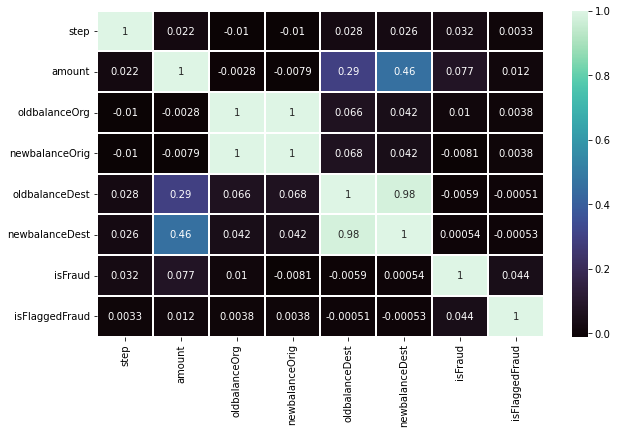

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), cmap='mako', linewidth=0.2, annot=True)
plt.show()

### Multi-Collinearity

In [124]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data.to_markdown())

|    | feature        |       VIF |
|---:|:---------------|----------:|
|  0 | step           |   1.19109 |
|  1 | amount         |   4.07895 |
|  2 | oldbalanceOrg  | 544.053   |
|  3 | newbalanceOrig | 546.346   |
|  4 | oldbalanceDest |  72.8955  |
|  5 | newbalanceDest |  84.5846  |
|  6 | isFraud        |   1.18839 |
|  7 | isFlaggedFraud |   1.00255 |
